# ProductListPriceHistory

## Import the required libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import torch

## Connecting to the database

In [14]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading the data

In [15]:
sql_query = "SELECT * FROM ProductListPriceHistory"
productlistpricehistory_df = read_data_return_df(sql_query, engine)

productlistpricehistory_df.head()

,PRODUCTLISTPRICEHISTORY_sk,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ProductID,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice,PRODUCTLISTPRICEHISTORY_datetime_added
0,1,222,2011-05-31,2012-05-29,33.6442,2024-05-26 17:15:13.933
1,2,222,2012-05-30,2013-05-29,33.6442,2024-05-26 17:15:13.933
2,3,222,2013-05-30,None,34.9900,2024-05-26 17:15:13.933
3,4,228,2011-05-31,2012-05-29,33.6442,2024-05-26 17:15:13.933
4,5,228,2012-05-30,2013-05-29,33.6442,2024-05-26 17:15:13.933


In [16]:
sql_query = "SELECT * FROM Product"
product_df = read_data_return_df(sql_query, engine)

product_df.head()

,PRODUCT_sk,PRODUCT_PRODUCT_ID,PRODUCT_UNITMEASURE_SIZE_ID,PRODUCT_UNITMEASURE_WEIGHT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID,PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID,PRODUCT_PMPDC_DescriptionID,...,PRODUCT_PRODUCTPHOTO_LargePhotoHexString,PRODUCT_PRODUCTPHOTO_LargePhotoFileName,PRODUCT_PRODUCT_SellStartDate,PRODUCT_DATE_SellStartDateFK,PRODUCT_PRODUCT_SellEndDate,PRODUCT_DATE_SellEndDateFK,PRODUCT_PRODUCT_DiscountedDate,PRODUCT_DATE_DiscountedDateFK,PRODUCT_PRODUCT_Discontinued,PRODUCT_datetime_added
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
2,3,3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
4,5,316,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597


## Data cleaning

In [17]:
# combining the two dataframes
combined_df = pd.merge(productlistpricehistory_df, product_df, left_on='PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ProductID', right_on='PRODUCT_sk')

# dropping the columns
drop_columns(combined_df)

In [18]:
# drop the unnecessary columns
columns_to_drop = ['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ProductID', 'PRODUCT_UNITMEASURE_SIZE_ID', 'PRODUCT_UNITMEASURE_WEIGHT_ID', 'PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID', 'PRODUCT_PMPDC_DescriptionID', 'PRODUCT_PRODUCT_Name', 'PRODUCT_PRODUCT_Number', 'PRODUCT_PRODUCT_MakeFlag', 'PRODUCT_PRODUCT_FinishedGoodsFlag', 'PRODUCT_PRODUCT_Color', 'PRODUCT_PRODUCTSUBCATEGORY_SubCategory', 'PRODUCT_PRODUCTCATEGORY_Category', 'PRODUCT_PRODUCTMODEL_Name', 'PRODUCT_PRODUCTMODEL_CatalogDescription', 'PRODUCT_PRODUCTMODEL_Instructions', 'PRODUCT_ILLUSTRATION_Diagram', 'PRODUCT_CULTURE_Name', 'PRODUCT_PRODUCTDESCRIPTION_Desc', 'PRODUCT_PRODUCTPRODUCTPHOTO_Primary', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhoto', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoHexString', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoFileName', 'PRODUCT_PRODUCTPHOTO_LargePhoto', 'PRODUCT_PRODUCTPHOTO_LargePhotoHexString', 'PRODUCT_PRODUCTPHOTO_LargePhotoFileName', 'PRODUCT_PRODUCT_SellStartDate', 'PRODUCT_PRODUCT_SellEndDate']

combined_df.drop(columns=columns_to_drop, inplace=True)

In [19]:
# converting the dates to integers (2013-05-30 to 20130530)
combined_df.fillna(-1, inplace=True)
combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate'] = combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate'].astype(str).str.replace('-', '').astype(int)
combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate'] = combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate'].astype(str).str.replace('-', '').astype(int)

combined_df['PRODUCT_PRODUCT_SubCategoryID'] = combined_df['PRODUCT_PRODUCT_SubCategoryID'].astype('category').cat.codes
combined_df['PRODUCT_PMPDC_CultureID'] = combined_df['PRODUCT_PMPDC_CultureID'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_ProductLine'] = combined_df['PRODUCT_PRODUCT_ProductLine'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Size'] = combined_df['PRODUCT_PRODUCT_Size'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Class'] = combined_df['PRODUCT_PRODUCT_Class'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Style'] = combined_df['PRODUCT_PRODUCT_Style'].astype('category').cat.codes

In [20]:
# dropping all rows where PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice is null/-1
combined_df = combined_df[combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice'] != -1]

In [21]:
# check for any string values
combined_df.dtypes

PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate      int32
PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate        int32
PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice    float64
PRODUCT_PRODUCT_ID                                             int64
PRODUCT_PRODUCT_SubCategoryID                                   int8
PRODUCT_PRODUCTSUBCATEGORY_CategoryID                        float64
PRODUCT_PRODUCT_ModelID                                      float64
PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID              float64
PRODUCT_PMPDC_CultureID                                         int8
PRODUCT_PRODUCT_SafetyStockLevel                             float64
PRODUCT_PRODUCT_ReorderPoint                                 float64
PRODUCT_PRODUCT_StandardCost                                 float64
PRODUCT_PRODUCT_ListPrice                                    float64
PRODUCT_PRODUCT_Size                                            int8
PRODUCT_PRODUCT_Weight            

In [22]:
combined_df

,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice,PRODUCT_PRODUCT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID,PRODUCT_PMPDC_CultureID,PRODUCT_PRODUCT_SafetyStockLevel,...,PRODUCT_PRODUCT_ListPrice,PRODUCT_PRODUCT_Size,PRODUCT_PRODUCT_Weight,PRODUCT_PRODUCT_DaysToManufacture,PRODUCT_PRODUCT_ProductLine,PRODUCT_PRODUCT_Class,PRODUCT_PRODUCT_Style,PRODUCT_DATE_SellStartDateFK,PRODUCT_DATE_SellEndDateFK,PRODUCT_DATE_DiscountedDateFK
0,20110531,20120529,33.6442,707,28,4.0,33.0,-1.0,2,4.0,...,34.99,0,-1.00,0.0,3,0,0,20110531,18000101,18000101
1,20120530,20130529,33.6442,707,28,4.0,33.0,-1.0,2,4.0,...,34.99,0,-1.00,0.0,3,0,0,20110531,18000101,18000101
2,20130530,1,34.9900,707,28,4.0,33.0,-1.0,2,4.0,...,34.99,0,-1.00,0.0,3,0,0,20110531,18000101,18000101
3,20110531,20120529,33.6442,708,28,4.0,33.0,-1.0,2,4.0,...,34.99,0,-1.00,0.0,3,0,0,20110531,18000101,18000101
4,20120530,20130529,33.6442,708,28,4.0,33.0,-1.0,2,4.0,...,34.99,0,-1.00,0.0,3,0,0,20110531,18000101,18000101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20130530,1,101.2400,995,4,2.0,96.0,-1.0,2,500.0,...,101.24,0,168.00,1.0,0,3,0,20130530,18000101,18000101
391,20130530,1,121.4900,996,4,2.0,97.0,-1.0,2,500.0,...,121.49,0,170.00,1.0,0,1,0,20130530,18000101,18000101
392,20130530,1,539.9900,997,1,1.0,31.0,-1.0,2,100.0,...,539.99,4,19.77,4.0,2,2,2,20130530,18000101,18000101
393,20130530,1,539.9900,998,1,1.0,31.0,-1.0,2,100.0,...,539.99,6,20.13,4.0,2,2,2,20130530,18000101,18000101


## Data preprocessing

### Splitting the data

In [23]:
# splitting the data
X = combined_df.drop(columns=['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice'])
y = combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training

### Linear Regression

In [24]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [26]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [27]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 30225.527777542968
R2 Score: 0.961613344542866


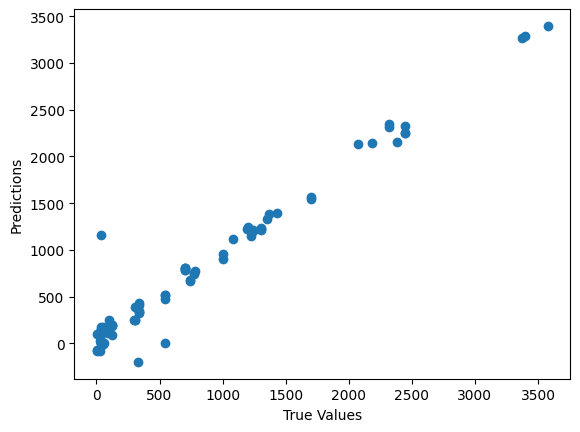

In [28]:
# visualizing the results
plt.scatter(y_test, lr_y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [29]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,1364.5000,1388.639272,-24.139272,24.139272,582.704434
371,1700.9900,1548.867305,152.122695,152.122695,23141.314327
248,89.9900,109.977275,-19.987275,19.987275,399.491151
55,337.2200,340.332380,-3.112380,3.112380,9.686911
390,101.2400,246.898098,-145.658098,145.658098,21216.281397
...,...,...,...,...,...
364,2384.0700,2155.135640,228.934360,228.934360,52410.941092
82,1240.4545,1210.859267,29.595233,29.595233,875.877808
114,699.0982,784.478891,-85.380691,85.380691,7289.862352
3,33.6442,5.134579,28.509621,28.509621,812.798461


### Decision Tree

In [30]:
# fitting the model
dtr_model = DecisionTreeRegressor()

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [31]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [32]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 18239.762200666133
R2 Score: 0.9768353600846885


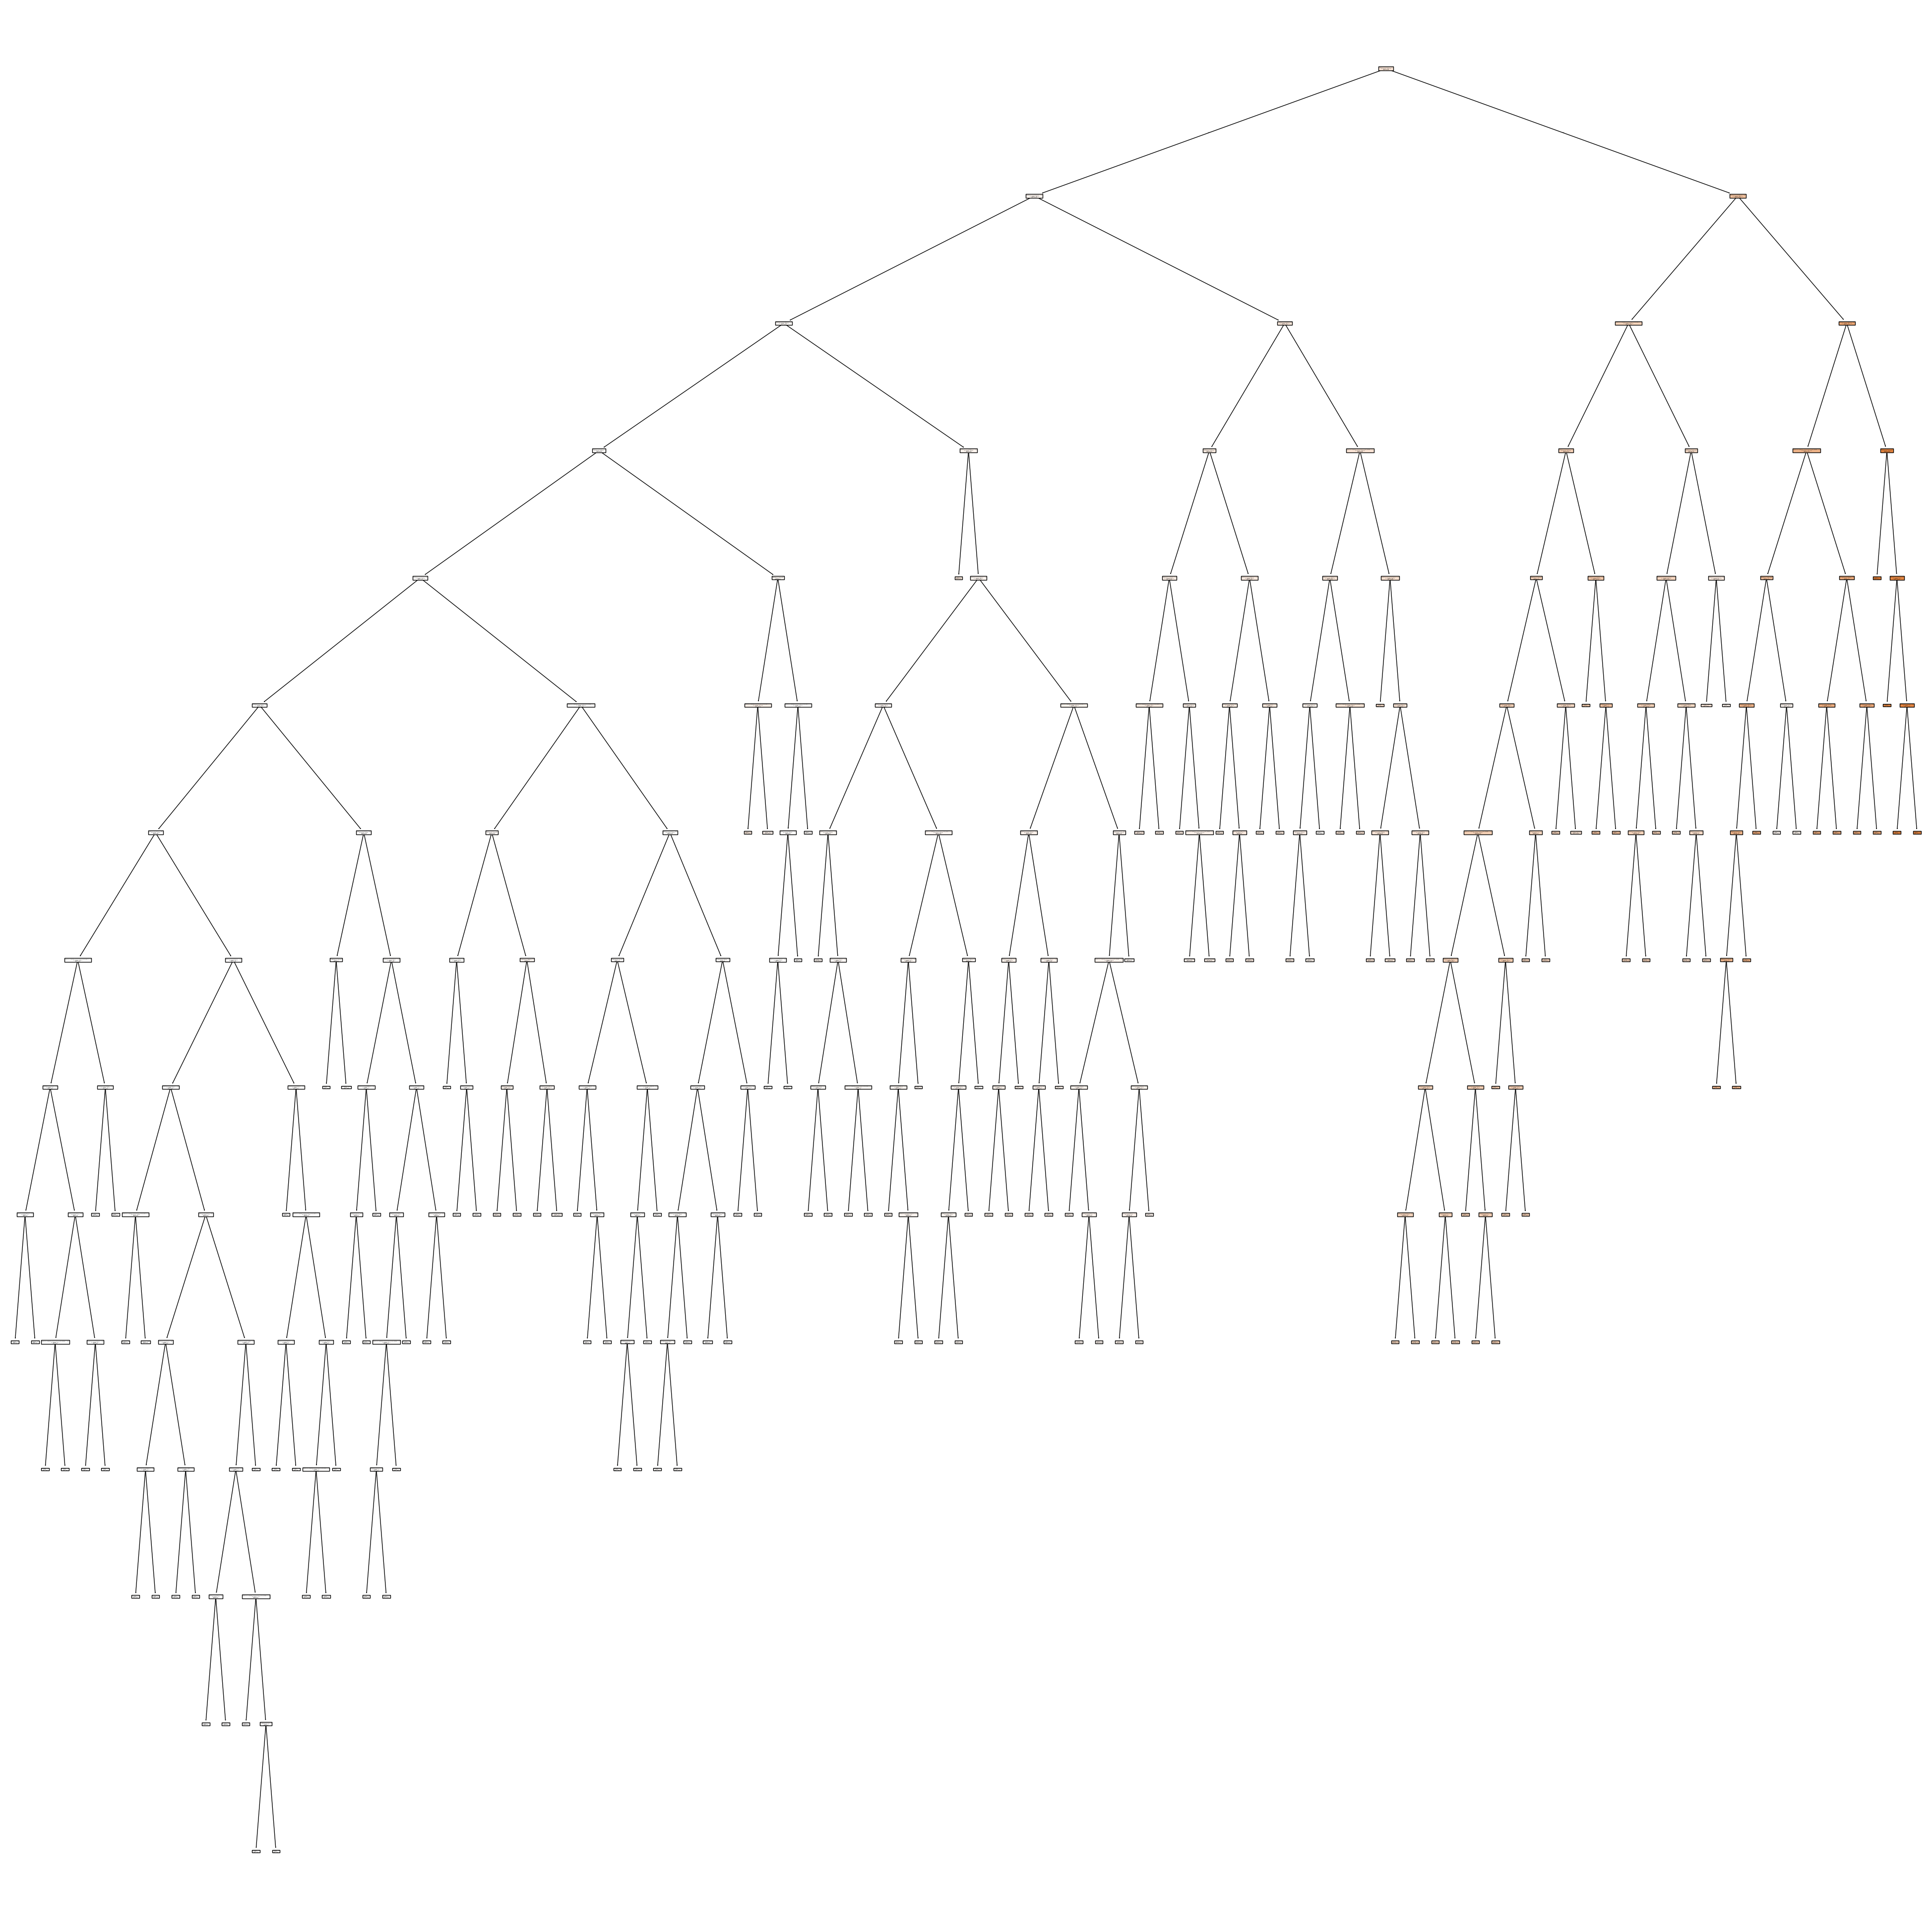

In [33]:
# visualizing the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dtr_model, filled=True, feature_names=X.columns)
plt.show()

In [34]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,1364.5000,1364.5000,0.000000e+00,0.000000e+00,0.000000e+00
371,1700.9900,1700.9900,0.000000e+00,0.000000e+00,0.000000e+00
248,89.9900,89.9900,0.000000e+00,0.000000e+00,0.000000e+00
55,337.2200,337.2200,0.000000e+00,0.000000e+00,0.000000e+00
390,101.2400,62.0900,3.915000e+01,3.915000e+01,1.532722e+03
...,...,...,...,...,...
364,2384.0700,2384.0700,0.000000e+00,0.000000e+00,0.000000e+00
82,1240.4545,1240.4545,0.000000e+00,0.000000e+00,0.000000e+00
114,699.0982,699.0982,-1.136868e-13,1.136868e-13,1.292470e-26
3,33.6442,33.6442,0.000000e+00,0.000000e+00,0.000000e+00


### Pytorch Network

In [35]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# converting the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [36]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=1000)

Epoch 0, Loss: 10543942656.0
Epoch 100, Loss: 627896.1875
Epoch 200, Loss: 532712.9375
Epoch 300, Loss: 540948.1875
Epoch 400, Loss: 352710.59375
Epoch 500, Loss: 480572.15625
Epoch 600, Loss: 991656.75
Epoch 700, Loss: 617372.9375
Epoch 800, Loss: 509741.03125
Epoch 900, Loss: 576213.875


#### Calculating the metrics and visualizing the results

In [37]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list)

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 765785.5625
Average R2 Score: -0.12496658166249593


In [38]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,1364.500000,4.304451,1360.195557,1360.195557,1.850132e+06
1,1700.989990,4.304451,1696.685547,1696.685547,2.878742e+06
2,89.989998,1036.007324,-946.017334,946.017334,8.949488e+05
3,337.220001,1097.038330,-759.818359,759.818359,5.773239e+05
4,101.239998,4.304451,96.935547,96.935547,9.396500e+03
...,...,...,...,...,...
74,2384.070068,4.304451,2379.765625,2379.765625,5.663284e+06
75,1240.454468,873.975220,366.479248,366.479248,1.343070e+05
76,699.098206,1201.096191,-501.997986,501.997986,2.520020e+05
77,33.644199,571.290405,-537.646179,537.646179,2.890634e+05
